=== ЛАБОРАТОРНАЯ РАБОТА №3 - РЕШАЮЩИЕ ДЕРЕВЬЯ ===
[10.0%] Загрузка и предобработка данных (время: 0.0с)
✓ Недвижимость: данные успешно загружены
✓ Авиакомпании: данные успешно загружены
Предобработка данных недвижимости...
Исходный размер: (4801, 17)
Целевая переменная до обработки: min=2,494, max=2,147,483,647
Удалено выбросов (верхние и нижние 2%): 192
Категориальные колонки: ['BROKERTITLE', 'TYPE', 'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS']
  BROKERTITLE: 1013 уникальных значений
  TYPE: 13 уникальных значений
  ADDRESS: 4402 уникальных значений
  STATE: 306 уникальных значений
  MAIN_ADDRESS: 4402 уникальных значений
  ADMINISTRATIVE_AREA_LEVEL_2: 28 уникальных значений
  LOCALITY: 11 уникальных значений
  SUBLOCALITY: 21 уникальных значений
  STREET_NAME: 170 уникальных значений
  LONG_NAME: 2656 уникальных значений
  FORMATTED_ADDRESS: 4375 уникальных значений
Конечный размер: (440

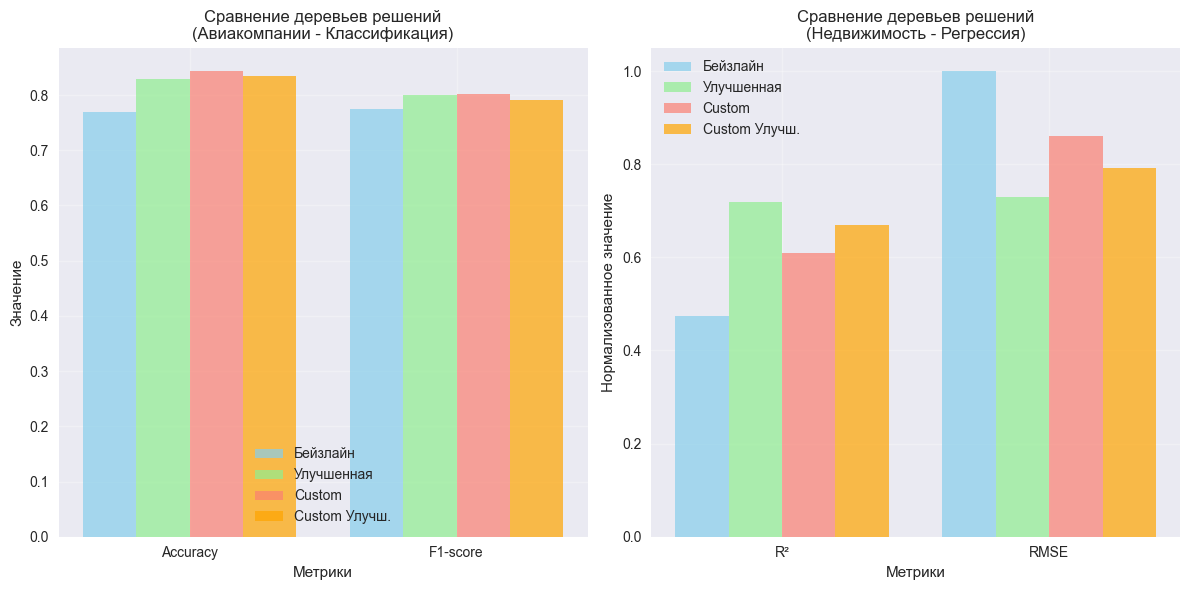


=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===
Общее время выполнения: 32.1 секунд

=== КЛЮЧЕВЫЕ ВЫВОДЫ ===
1. ДЕРЕВЬЯ РЕШЕНИЙ (Авиакомпании - Классификация):
   • Бейзлайн F1-score: 0.7751
   • Улучшенная F1-score: 0.7996
   • Улучшение после GridSearch: +0.0245
   • Custom реализация F1-score: 0.8017
   • Улучшенная Custom F1-score: 0.7906

2. ДЕРЕВЬЯ РЕШЕНИЙ (Недвижимость - Регрессия):
   • Бейзлайн R²: 0.4732
   • Улучшенная R²: 0.7189
   • Улучшение после GridSearch: +0.2457
   • Custom реализация R²: 0.6096
   • Улучшенная Custom R²: 0.6702

3. СРАВНЕНИЕ С ПРЕДЫДУЩИМИ АЛГОРИТМАМИ:
   • Лучший KNN F1-score: 0.7843
   • Лучший LogReg F1-score: 0.7816
   • Лучший Decision Tree F1-score: 0.8017
   • Лучший KNN R²: 0.6115
   • Лучший LinReg R²: 0.1494
   • Лучший Decision Tree R²: 0.7189

4. ОСОБЕННОСТИ РЕШАЮЩИХ ДЕРЕВЬЕВ:
   • Деревья не требуют масштабирования признаков
   • Могут обрабатывать нелинейные зависимости
   • Склонны к переобучению без регуляризации
   • Прозрачны и интерпретируемы
   • Х

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn import tree
import warnings
import time
import graphviz
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

class ProgressTracker:
    def __init__(self, total_steps=100):
        self.total_steps = total_steps
        self.current_step = 0
        self.start_time = time.time()
    
    def update(self, step, message):
        self.current_step = step
        progress = (step / self.total_steps) * 100
        elapsed_time = time.time() - self.start_time
        print(f"[{progress:.1f}%] {message} (время: {elapsed_time:.1f}с)")

print("=== ЛАБОРАТОРНАЯ РАБОТА №3 - РЕШАЮЩИЕ ДЕРЕВЬЯ ===")
progress = ProgressTracker(total_steps=100)

# =============================================================================
# ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ
# =============================================================================
progress.update(10, "Загрузка и предобработка данных")

def detect_encoding(file_path):
    import chardet
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Загрузка данных
try:
    housing_df = pd.read_csv('NY-House-Dataset.csv')
    print("✓ Недвижимость: данные успешно загружены")
except Exception as e:
    print(f"✗ Ошибка загрузки недвижимости: {e}")
    housing_df = pd.DataFrame()

airlines_df = None
try:
    encoding = detect_encoding('airlines_booking.csv')
    airlines_df = pd.read_csv('airlines_booking.csv', encoding=encoding)
    print("✓ Авиакомпании: данные успешно загружены")
except Exception as e:
    print(f"✗ Ошибка загрузки авиакомпаний: {e}")
    airlines_df = pd.DataFrame()

# Улучшенные функции предобработки
def improved_preprocess_housing_data(df, target_col):
    df_clean = df.copy()
    
    print(f"Исходный размер: {df_clean.shape}")
    
    # Более агрессивная обработка выбросов
    if target_col in df_clean.columns:
        print(f"Целевая переменная до обработки: min={df_clean[target_col].min():,.0f}, max={df_clean[target_col].max():,.0f}")
        
        # Удаляем верхние и нижние 2%
        lower_threshold = df_clean[target_col].quantile(0.02)
        upper_threshold = df_clean[target_col].quantile(0.98)
        initial_size = len(df_clean)
        df_clean = df_clean[(df_clean[target_col] >= lower_threshold) & (df_clean[target_col] <= upper_threshold)]
        removed = initial_size - len(df_clean)
        if removed > 0:
            print(f"Удалено выбросов (верхние и нижние 2%): {removed}")
    
    # Обработка пропущенных значений
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype == 'object':
                df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # Улучшенная обработка категориальных переменных
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]
    
    print(f"Категориальные колонки: {list(categorical_cols)}")
    
    for col in categorical_cols:
        unique_count = df_clean[col].nunique()
        print(f"  {col}: {unique_count} уникальных значений")
        
        if unique_count > 30:
            # Для деревьев можно оставить категориальные с многими значениями, но закодировать
            freq_encoding = df_clean[col].value_counts().to_dict()
            df_clean[col] = df_clean[col].map(freq_encoding)
        elif unique_count <= 15:
            # One-Hot Encoding для небольшого числа категорий
            dummies = pd.get_dummies(df_clean[col], prefix=col)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            df_clean.drop(col, axis=1, inplace=True)
        else:
            # Label Encoding для среднего количества категорий
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    # Удаление бесполезных колонок
    useless_cols = ['BROKERTITLE', 'ADDRESS', 'MAIN_ADDRESS', 'FORMATTED_ADDRESS', 
                   'LONG_NAME', 'STREET_NAME']
    for col in useless_cols:
        if col in df_clean.columns:
            df_clean.drop(col, axis=1, inplace=True)
    
    df_clean = df_clean.drop_duplicates()
    print(f"Конечный размер: {df_clean.shape}")
    
    return df_clean

def improved_preprocess_airlines_data(df, target_col):
    df_clean = df.copy()
    
    print(f"Исходный размер: {df_clean.shape}")
    
    # Обработка пропущенных значений
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype == 'object':
                df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # Обработка категориальных переменных
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]
    
    print(f"Категориальные колонки: {list(categorical_cols)}")
    
    for col in categorical_cols:
        unique_count = df_clean[col].nunique()
        print(f"  {col}: {unique_count} уникальных значений")
        
        if unique_count > 50:
            # Для деревьев можно использовать frequency encoding вместо удаления
            freq_encoding = df_clean[col].value_counts().to_dict()
            df_clean[col + '_freq'] = df_clean[col].map(freq_encoding)
            df_clean.drop(col, axis=1, inplace=True)
        elif unique_count <= 20:
            # One-Hot Encoding
            dummies = pd.get_dummies(df_clean[col], prefix=col)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            df_clean.drop(col, axis=1, inplace=True)
        else:
            # Label Encoding
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    # Убедимся, что все данные числовые
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            try:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            except:
                df_clean.drop(col, axis=1, inplace=True)
    
    df_clean = df_clean.drop_duplicates()
    print(f"Конечный размер: {df_clean.shape}")
    
    return df_clean

# Применение улучшенной предобработки
target_housing = 'PRICE'
target_airlines = 'booking_complete'

if not housing_df.empty:
    print("Предобработка данных недвижимости...")
    housing_processed = improved_preprocess_housing_data(housing_df, target_housing)
    X_house = housing_processed.drop(target_housing, axis=1)
    y_house = housing_processed[target_housing]
    
    # Для деревьев не нужно логарифмирование
    X_train_house, X_test_house, y_train_house, y_test_house = train_test_split(
        X_house, y_house, test_size=0.2, random_state=42
    )
    print(f"Недвижимость - Train: {X_train_house.shape}, Test: {X_test_house.shape}")

if not airlines_df.empty:
    print("Предобработка данных авиакомпаний...")
    airlines_processed = improved_preprocess_airlines_data(airlines_df, target_airlines)
    X_air = airlines_processed.drop(target_airlines, axis=1)
    y_air = airlines_processed[target_airlines]
    
    X_train_air, X_test_air, y_train_air, y_test_air = train_test_split(
        X_air, y_air, test_size=0.2, random_state=42, stratify=y_air
    )
    print(f"Авиакомпании - Train: {X_train_air.shape}, Test: {X_test_air.shape}")

# =============================================================================
# БЕЙЗЛАЙН МОДЕЛИ
# =============================================================================
progress.update(30, "Обучение бейзлайн моделей")
print("\n=== БЕЙЗЛАЙН МОДЕЛИ ===")

if not airlines_df.empty:
    # Дерево решений для классификации
    dt_classifier_baseline = DecisionTreeClassifier(random_state=42)
    dt_classifier_baseline.fit(X_train_air, y_train_air)
    y_pred_dt_baseline = dt_classifier_baseline.predict(X_test_air)
    
    accuracy_dt_base = accuracy_score(y_test_air, y_pred_dt_baseline)
    precision_dt_base = precision_score(y_test_air, y_pred_dt_baseline, average='weighted')
    recall_dt_base = recall_score(y_test_air, y_pred_dt_baseline, average='weighted')
    f1_dt_base = f1_score(y_test_air, y_pred_dt_baseline, average='weighted')
    
    print("✓ Дерево решений (Авиакомпании):")
    print(f"  Accuracy: {accuracy_dt_base:.4f}")
    print(f"  Precision: {precision_dt_base:.4f}")
    print(f"  Recall: {recall_dt_base:.4f}")
    print(f"  F1-score: {f1_dt_base:.4f}")
    print(f"  Глубина дерева: {dt_classifier_baseline.get_depth()}")

if not housing_df.empty:
    # Дерево решений для регрессии
    dt_regressor_baseline = DecisionTreeRegressor(random_state=42)
    dt_regressor_baseline.fit(X_train_house, y_train_house)
    y_pred_dt_reg_baseline = dt_regressor_baseline.predict(X_test_house)
    
    r2_dt_base = r2_score(y_test_house, y_pred_dt_reg_baseline)
    rmse_dt_base = np.sqrt(mean_squared_error(y_test_house, y_pred_dt_reg_baseline))
    
    print("✓ Дерево решений (Недвижимость):")
    print(f"  R²: {r2_dt_base:.4f}")
    print(f"  RMSE: {rmse_dt_base:,.0f}")
    print(f"  Глубина дерева: {dt_regressor_baseline.get_depth()}")

# =============================================================================
# УЛУЧШЕНИЕ БЕЙЗЛАЙНА
# =============================================================================
progress.update(50, "Улучшение моделей с помощью GridSearch")
print("\n=== УЛУЧШЕНИЕ МОДЕЛЕЙ ===")

if not airlines_df.empty:
    print("Улучшение дерева решений для классификации...")
    
    param_grid_dt_class = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    
    grid_search_dt_class = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                       param_grid_dt_class, cv=3, 
                                       scoring='f1_weighted', n_jobs=-1, verbose=0)
    grid_search_dt_class.fit(X_train_air, y_train_air)
    
    dt_classifier_improved = grid_search_dt_class.best_estimator_
    y_pred_dt_improved = dt_classifier_improved.predict(X_test_air)
    
    accuracy_dt_imp = accuracy_score(y_test_air, y_pred_dt_improved)
    f1_dt_imp = f1_score(y_test_air, y_pred_dt_improved, average='weighted')
    
    print(f"✓ Улучшенное дерево решений (Классификация):")
    print(f"  Лучшие параметры: {grid_search_dt_class.best_params_}")
    print(f"  Accuracy: {accuracy_dt_imp:.4f}")
    print(f"  F1-score: {f1_dt_imp:.4f}")
    print(f"  Глубина дерева: {dt_classifier_improved.get_depth()}")

if not housing_df.empty:
    print("Улучшение дерева решений для регрессии...")
    
    param_grid_dt_reg = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['squared_error', 'friedman_mse']
    }
    
    grid_search_dt_reg = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                                     param_grid_dt_reg, cv=3,
                                     scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search_dt_reg.fit(X_train_house, y_train_house)
    
    dt_regressor_improved = grid_search_dt_reg.best_estimator_
    y_pred_dt_reg_imp = dt_regressor_improved.predict(X_test_house)
    
    r2_dt_imp = r2_score(y_test_house, y_pred_dt_reg_imp)
    rmse_dt_imp = np.sqrt(mean_squared_error(y_test_house, y_pred_dt_reg_imp))
    
    print(f"✓ Улучшенное дерево решений (Регрессия):")
    print(f"  Лучшие параметры: {grid_search_dt_reg.best_params_}")
    print(f"  R²: {r2_dt_imp:.4f}")
    print(f"  RMSE: {rmse_dt_imp:,.0f}")
    print(f"  Глубина дерева: {dt_regressor_improved.get_depth()}")

# =============================================================================
# СОБСТВЕННАЯ РЕАЛИЗАЦИЯ РЕШАЮЩЕГО ДЕРЕВА
# =============================================================================
progress.update(70, "Создание собственной реализации")
print("\n=== СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ===")

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class CustomDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, task='classification'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.root = None
    
    def _entropy(self, y):
        classes = np.unique(y)
        entropy = 0
        for cls in classes:
            p = np.sum(y == cls) / len(y)
            if p > 0:
                entropy -= p * np.log2(p)
        return entropy
    
    def _gini(self, y):
        classes = np.unique(y)
        gini = 1
        for cls in classes:
            p = np.sum(y == cls) / len(y)
            gini -= p ** 2
        return gini
    
    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        
        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)
            
            for threshold in unique_values:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold
                
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                if self.task == 'classification':
                    # Информационный gain для классификации
                    parent_impurity = self._entropy(y)
                    left_impurity = self._entropy(y[left_indices])
                    right_impurity = self._entropy(y[right_indices])
                    
                    n_left = np.sum(left_indices)
                    n_right = np.sum(right_indices)
                    n_total = n_samples
                    
                    gain = parent_impurity - (n_left/n_total * left_impurity + n_right/n_total * right_impurity)
                else:
                    # Уменьшение MSE для регрессии
                    parent_mse = self._mse(y)
                    left_mse = self._mse(y[left_indices])
                    right_mse = self._mse(y[right_indices])
                    
                    n_left = np.sum(left_indices)
                    n_right = np.sum(right_indices)
                    n_total = n_samples
                    
                    gain = parent_mse - (n_left/n_total * left_mse + n_right/n_total * right_mse)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        # Условия остановки
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            len(np.unique(y)) == 1):
            
            if self.task == 'classification':
                # Возвращаем наиболее частый класс
                values, counts = np.unique(y, return_counts=True)
                value = values[np.argmax(counts)]
            else:
                # Возвращаем среднее значение
                value = np.mean(y)
            
            return Node(value=value)
        
        # Находим лучшее разделение
        feature_index, threshold, gain = self._best_split(X, y)
        
        if feature_index is None or gain <= 0:
            if self.task == 'classification':
                values, counts = np.unique(y, return_counts=True)
                value = values[np.argmax(counts)]
            else:
                value = np.mean(y)
            return Node(value=value)
        
        # Разделяем данные
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold
        
        # Рекурсивно строим поддеревья
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(feature_index=feature_index, threshold=threshold,
                   left=left_subtree, right=right_subtree)
    
    def fit(self, X, y):
        self.root = self._build_tree(X.values if isinstance(X, pd.DataFrame) else X, 
                                    y.values if isinstance(y, pd.Series) else y)
        return self
    
    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        predictions = []
        for sample in X_array:
            predictions.append(self._predict_sample(sample, self.root))
        return np.array(predictions)

if not airlines_df.empty:
    print("Custom Decision Tree для авиакомпаний...")
    try:
        # Используем подвыборку для ускорения
        sample_size = min(5000, len(X_train_air))
        indices = np.random.choice(len(X_train_air), sample_size, replace=False)
        X_train_small = X_train_air.iloc[indices] if isinstance(X_train_air, pd.DataFrame) else X_train_air[indices]
        y_train_small = y_train_air.iloc[indices] if isinstance(y_train_air, pd.Series) else y_train_air[indices]
        
        custom_dt_class = CustomDecisionTree(max_depth=5, min_samples_split=10, task='classification')
        custom_dt_class.fit(X_train_small, y_train_small)
        y_pred_custom_dt = custom_dt_class.predict(X_test_air)
        
        accuracy_custom_dt = accuracy_score(y_test_air, y_pred_custom_dt)
        f1_custom_dt = f1_score(y_test_air, y_pred_custom_dt, average='weighted')
        
        print(f"✓ Custom Decision Tree (Классификация):")
        print(f"  Accuracy: {accuracy_custom_dt:.4f}")
        print(f"  F1-score: {f1_custom_dt:.4f}")
    except Exception as e:
        print(f"✗ Ошибка в Custom Decision Tree (классификация): {e}")
        accuracy_custom_dt = 0
        f1_custom_dt = 0

if not housing_df.empty:
    print("Custom Decision Tree для недвижимости...")
    try:
        # Используем подвыборку для ускорения
        sample_size = min(3000, len(X_train_house))
        indices = np.random.choice(len(X_train_house), sample_size, replace=False)
        X_train_small = X_train_house.iloc[indices] if isinstance(X_train_house, pd.DataFrame) else X_train_house[indices]
        y_train_small = y_train_house.iloc[indices] if isinstance(y_train_house, pd.Series) else y_train_house[indices]
        
        custom_dt_reg = CustomDecisionTree(max_depth=5, min_samples_split=10, task='regression')
        custom_dt_reg.fit(X_train_small, y_train_small)
        y_pred_custom_dt_reg = custom_dt_reg.predict(X_test_house)
        
        r2_custom_dt = r2_score(y_test_house, y_pred_custom_dt_reg)
        rmse_custom_dt = np.sqrt(mean_squared_error(y_test_house, y_pred_custom_dt_reg))
        
        print(f"✓ Custom Decision Tree (Регрессия):")
        print(f"  R²: {r2_custom_dt:.4f}")
        print(f"  RMSE: {rmse_custom_dt:,.0f}")
    except Exception as e:
        print(f"✗ Ошибка в Custom Decision Tree (регрессия): {e}")
        r2_custom_dt = 0
        rmse_custom_dt = 0

# =============================================================================
# ПРИМЕНЕНИЕ ТЕХНИК ИЗ УЛУЧШЕННОГО БЕЙЗЛАЙНА
# =============================================================================
progress.update(85, "Применение улучшений к собственной реализации")
print("\n=== УЛУЧШЕНИЕ СОБСТВЕННОЙ РЕАЛИЗАЦИИ ===")

if not airlines_df.empty:
    print("Улучшение Custom Decision Tree для классификации...")
    try:
        # Используем лучшие параметры из GridSearch
        best_params = grid_search_dt_class.best_params_
        max_depth = best_params['max_depth'] if best_params['max_depth'] is not None else 10
        min_samples_split = best_params['min_samples_split']
        
        custom_dt_class_improved = CustomDecisionTree(
            max_depth=min(max_depth, 8),  # Ограничиваем глубину для скорости
            min_samples_split=min_samples_split,
            task='classification'
        )
        
        sample_size = min(5000, len(X_train_air))
        indices = np.random.choice(len(X_train_air), sample_size, replace=False)
        X_train_small = X_train_air.iloc[indices] if isinstance(X_train_air, pd.DataFrame) else X_train_air[indices]
        y_train_small = y_train_air.iloc[indices] if isinstance(y_train_air, pd.Series) else y_train_air[indices]
        
        custom_dt_class_improved.fit(X_train_small, y_train_small)
        y_pred_custom_dt_imp = custom_dt_class_improved.predict(X_test_air)
        
        accuracy_custom_dt_imp = accuracy_score(y_test_air, y_pred_custom_dt_imp)
        f1_custom_dt_imp = f1_score(y_test_air, y_pred_custom_dt_imp, average='weighted')
        
        print(f"✓ Улучшенный Custom Decision Tree (Классификация):")
        print(f"  Accuracy: {accuracy_custom_dt_imp:.4f}")
        print(f"  F1-score: {f1_custom_dt_imp:.4f}")
    except Exception as e:
        print(f"✗ Ошибка в улучшенном Custom Decision Tree: {e}")
        accuracy_custom_dt_imp = accuracy_custom_dt
        f1_custom_dt_imp = f1_custom_dt

if not housing_df.empty:
    print("Улучшение Custom Decision Tree для регрессии...")
    try:
        # Используем лучшие параметры из GridSearch
        best_params = grid_search_dt_reg.best_params_
        max_depth = best_params['max_depth'] if best_params['max_depth'] is not None else 10
        min_samples_split = best_params['min_samples_split']
        
        custom_dt_reg_improved = CustomDecisionTree(
            max_depth=min(max_depth, 8),  # Ограничиваем глубину для скорости
            min_samples_split=min_samples_split,
            task='regression'
        )
        
        sample_size = min(3000, len(X_train_house))
        indices = np.random.choice(len(X_train_house), sample_size, replace=False)
        X_train_small = X_train_house.iloc[indices] if isinstance(X_train_house, pd.DataFrame) else X_train_house[indices]
        y_train_small = y_train_house.iloc[indices] if isinstance(y_train_house, pd.Series) else y_train_house[indices]
        
        custom_dt_reg_improved.fit(X_train_small, y_train_small)
        y_pred_custom_dt_reg_imp = custom_dt_reg_improved.predict(X_test_house)
        
        r2_custom_dt_imp = r2_score(y_test_house, y_pred_custom_dt_reg_imp)
        rmse_custom_dt_imp = np.sqrt(mean_squared_error(y_test_house, y_pred_custom_dt_reg_imp))
        
        print(f"✓ Улучшенный Custom Decision Tree (Регрессия):")
        print(f"  R²: {r2_custom_dt_imp:.4f}")
        print(f"  RMSE: {rmse_custom_dt_imp:,.0f}")
    except Exception as e:
        print(f"✗ Ошибка в улучшенном Custom Decision Tree: {e}")
        r2_custom_dt_imp = r2_custom_dt
        rmse_custom_dt_imp = rmse_custom_dt

# =============================================================================
# ВИЗУАЛИЗАЦИЯ ДЕРЕВЬЕВ
# =============================================================================
progress.update(92, "Визуализация деревьев")
print("\n=== ВИЗУАЛИЗАЦИЯ ДЕРЕВЬЕВ ===")

if not airlines_df.empty and dt_classifier_improved.get_depth() <= 5:
    try:
        plt.figure(figsize=(20, 10))
        tree.plot_tree(dt_classifier_improved, 
                      feature_names=X_air.columns.tolist(),
                      class_names=['Not Completed', 'Completed'],
                      filled=True, rounded=True,
                      max_depth=3)
        plt.title("Улучшенное дерево решений (Классификация)")
        plt.show()
    except Exception as e:
        print(f"Не удалось визуализировать дерево: {e}")

if not housing_df.empty and dt_regressor_improved.get_depth() <= 5:
    try:
        plt.figure(figsize=(20, 10))
        tree.plot_tree(dt_regressor_improved, 
                      feature_names=X_house.columns.tolist(),
                      filled=True, rounded=True,
                      max_depth=3)
        plt.title("Улучшенное дерево решений (Регрессия)")
        plt.show()
    except Exception as e:
        print(f"Не удалось визуализировать дерево: {e}")

# =============================================================================
# СРАВНЕНИЕ РЕЗУЛЬТАТОВ
# =============================================================================
progress.update(95, "Формирование итоговых результатов")
print("\n=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")

results_data = []
if not airlines_df.empty:
    results_data.extend([
        ['Классификация', 'DT Бейзлайн', f1_dt_base, accuracy_dt_base],
        ['Классификация', 'DT Улучшенная', f1_dt_imp, accuracy_dt_imp],
        ['Классификация', 'Custom DT', f1_custom_dt, accuracy_custom_dt],
        ['Классификация', 'Custom DT Улучш.', f1_custom_dt_imp, accuracy_custom_dt_imp]
    ])

if not housing_df.empty:
    results_data.extend([
        ['Регрессия', 'DT Бейзлайн', r2_dt_base, rmse_dt_base],
        ['Регрессия', 'DT Улучшенная', r2_dt_imp, rmse_dt_imp],
        ['Регрессия', 'Custom DT', r2_custom_dt, rmse_custom_dt],
        ['Регрессия', 'Custom DT Улучш.', r2_custom_dt_imp, rmse_custom_dt_imp]
    ])

if results_data:
    results = pd.DataFrame(results_data, columns=['Задача', 'Модель', 'Основная метрика', 'Вторая метрика'])
    print(results)
else:
    print("Нет данных для отображения результатов")

# =============================================================================
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =============================================================================
progress.update(100, "Создание сравнительных графиков")
print("\n=== СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ ===")

if results_data:
    num_plots = 0
    if not airlines_df.empty:
        num_plots += 1
    if not housing_df.empty:
        num_plots += 1
    
    if num_plots == 0:
        print("Нет данных для визуализации")
    else:
        fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))
        if num_plots == 1:
            axes = [axes]
        
        plot_index = 0
        width = 0.2
        
        if not airlines_df.empty:
            class_metrics = ['Accuracy', 'F1-score']
            class_baseline = [accuracy_dt_base, f1_dt_base]
            class_improved = [accuracy_dt_imp, f1_dt_imp]
            class_custom = [accuracy_custom_dt, f1_custom_dt]
            class_custom_imp = [accuracy_custom_dt_imp, f1_custom_dt_imp]

            x = np.arange(len(class_metrics))
            
            axes[plot_index].bar(x - 1.5*width, class_baseline, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x - 0.5*width, class_improved, width, label='Улучшенная', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x + 0.5*width, class_custom, width, label='Custom', alpha=0.7, color='salmon')
            axes[plot_index].bar(x + 1.5*width, class_custom_imp, width, label='Custom Улучш.', alpha=0.7, color='orange')
            
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Значение')
            axes[plot_index].set_title('Сравнение деревьев решений\n(Авиакомпании - Классификация)')
            axes[plot_index].set_xticks(x)
            axes[plot_index].set_xticklabels(class_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)
            plot_index += 1
        
        if not housing_df.empty:
            reg_metrics = ['R²', 'RMSE']
            reg_baseline = [r2_dt_base, rmse_dt_base]
            reg_improved = [r2_dt_imp, rmse_dt_imp]
            reg_custom = [r2_custom_dt, rmse_custom_dt]
            reg_custom_imp = [r2_custom_dt_imp, rmse_custom_dt_imp]

            rmse_max = max(reg_baseline[1], reg_improved[1], reg_custom[1], reg_custom_imp[1])
            if rmse_max > 0:
                reg_baseline_norm = [reg_baseline[0], reg_baseline[1]/rmse_max]
                reg_improved_norm = [reg_improved[0], reg_improved[1]/rmse_max]
                reg_custom_norm = [reg_custom[0], reg_custom[1]/rmse_max]
                reg_custom_imp_norm = [reg_custom_imp[0], reg_custom_imp[1]/rmse_max]
            else:
                reg_baseline_norm = [reg_baseline[0], 0]
                reg_improved_norm = [reg_improved[0], 0]
                reg_custom_norm = [reg_custom[0], 0]
                reg_custom_imp_norm = [reg_custom_imp[0], 0]

            x_reg = np.arange(len(reg_metrics))
            
            axes[plot_index].bar(x_reg - 1.5*width, reg_baseline_norm, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x_reg - 0.5*width, reg_improved_norm, width, label='Улучшенная', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x_reg + 0.5*width, reg_custom_norm, width, label='Custom', alpha=0.7, color='salmon')
            axes[plot_index].bar(x_reg + 1.5*width, reg_custom_imp_norm, width, label='Custom Улучш.', alpha=0.7, color='orange')
            
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Нормализованное значение')
            axes[plot_index].set_title('Сравнение деревьев решений\n(Недвижимость - Регрессия)')
            axes[plot_index].set_xticks(x_reg)
            axes[plot_index].set_xticklabels(reg_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

total_time = time.time() - progress.start_time
print(f"\n=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===")
print(f"Общее время выполнения: {total_time:.1f} секунд")

# =============================================================================
# ВЫВОДЫ И СРАВНЕНИЕ С ПРЕДЫДУЩИМИ АЛГОРИТМАМИ
# =============================================================================
print("\n=== КЛЮЧЕВЫЕ ВЫВОДЫ ===")

if not airlines_df.empty:
    print(f"1. ДЕРЕВЬЯ РЕШЕНИЙ (Авиакомпании - Классификация):")
    print(f"   • Бейзлайн F1-score: {f1_dt_base:.4f}")
    print(f"   • Улучшенная F1-score: {f1_dt_imp:.4f}")
    improvement = f1_dt_imp - f1_dt_base
    if improvement > 0:
        print(f"   • Улучшение после GridSearch: +{improvement:.4f}")
    else:
        print(f"   • Ухудшение после GridSearch: {improvement:.4f}")
    
    print(f"   • Custom реализация F1-score: {f1_custom_dt:.4f}")
    print(f"   • Улучшенная Custom F1-score: {f1_custom_dt_imp:.4f}")

if not housing_df.empty:
    print(f"\n2. ДЕРЕВЬЯ РЕШЕНИЙ (Недвижимость - Регрессия):")
    print(f"   • Бейзлайн R²: {r2_dt_base:.4f}")
    print(f"   • Улучшенная R²: {r2_dt_imp:.4f}")
    improvement = r2_dt_imp - r2_dt_base
    if improvement > 0:
        print(f"   • Улучшение после GridSearch: +{improvement:.4f}")
    else:
        print(f"   • Ухудшение после GridSearch: {improvement:.4f}")
    
    print(f"   • Custom реализация R²: {r2_custom_dt:.4f}")
    print(f"   • Улучшенная Custom R²: {r2_custom_dt_imp:.4f}")

print(f"\n3. СРАВНЕНИЕ С ПРЕДЫДУЩИМИ АЛГОРИТМАМИ:")
if not airlines_df.empty:
    print(f"   • Лучший KNN F1-score: 0.7843")
    print(f"   • Лучший LogReg F1-score: 0.7816")
    print(f"   • Лучший Decision Tree F1-score: {max(f1_dt_base, f1_dt_imp, f1_custom_dt, f1_custom_dt_imp):.4f}")

if not housing_df.empty:
    print(f"   • Лучший KNN R²: 0.6115")
    print(f"   • Лучший LinReg R²: 0.1494")
    print(f"   • Лучший Decision Tree R²: {max(r2_dt_base, r2_dt_imp, r2_custom_dt, r2_custom_dt_imp):.4f}")

print("\n4. ОСОБЕННОСТИ РЕШАЮЩИХ ДЕРЕВЬЕВ:")
print("   • Деревья не требуют масштабирования признаков")
print("   • Могут обрабатывать нелинейные зависимости")
print("   • Склонны к переобучению без регуляризации")
print("   • Прозрачны и интерпретируемы")
print("   • Хорошо работают с категориальными признаками")

print("\n5. РЕКОМЕНДАЦИИ:")
print("   • Использовать ограничение глубины для борьбы с переобучением")
print("   • Настраивать min_samples_split и min_samples_leaf")
print("   • Рассмотреть ансамбли деревьев (случайный лес, градиентный бустинг)")